# References:
1. Ref1: https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

2. Ref2: https://arxiv.org/abs/1512.03385

3. Ref3: https://www.youtube.com/watch?v=DkNIBBBvcPs

# Importing Libraries 

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary


import torchvision
import torchvision.transforms as transforms

import time
import sys
import os
from PIL import Image
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
!nvidia-smi

Sat Apr  1 21:24:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset

This is mainly copied directly from the Ref1, and slightly modified.

In [ ]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),

    # Added augmentation
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.2, interpolation=3, fill=0),

    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)



testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Constructing ResNet

This is mainly copied directly from the Ref1, with some modification.

In [ ]:
# Defining the Basic Block for the ResNet.

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# Construct ResNet

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 100, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
# Show total number of parameters
net = ResNet(BasicBlock, [2, 2, 2, 2]).to('cuda')
net = torch.nn.DataParallel(net)
# y = net(torch.randn(1, 3, 32, 32).to('cuda'))
# print(y.size())
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 100, 16, 16]          57,600
      BatchNorm2d-14          [-1, 100,

# Training 

This is mainly copied directly from the Ref1, with some modification.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    print(f'Train Accuracy:{acc}%')

def test(epoch):
    global best_acc

    net.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):

            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, targets)

            test_loss += loss.item()

            _, predicted = outputs.max(1)

            total += targets.size(0)

            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    print(f'Test Accuracy:{acc}%')
    
    # Save checkpoint.
    
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
for epoch in range(200):
    t0 = time.time()
    train(epoch)
    test(epoch)
    scheduler.step()
    t1 = time.time() - t0
    print(f'Used {int(t1)} seconds')


Epoch: 0
Train Accuracy:29.124%
Test Accuracy:43.93%
Saving..
Used 30 seconds

Epoch: 1
Train Accuracy:48.754%
Test Accuracy:46.11%
Saving..
Used 30 seconds

Epoch: 2
Train Accuracy:57.56%
Test Accuracy:44.68%
Used 30 seconds

Epoch: 3
Train Accuracy:61.386%
Test Accuracy:63.55%
Saving..
Used 30 seconds

Epoch: 4
Train Accuracy:65.13%
Test Accuracy:68.56%
Saving..
Used 30 seconds

Epoch: 5
Train Accuracy:67.372%
Test Accuracy:72.12%
Saving..
Used 30 seconds

Epoch: 6
Train Accuracy:69.122%
Test Accuracy:70.53%
Used 30 seconds

Epoch: 7
Train Accuracy:71.05%
Test Accuracy:68.32%
Used 30 seconds

Epoch: 8
Train Accuracy:72.196%
Test Accuracy:74.78%
Saving..
Used 30 seconds

Epoch: 9
Train Accuracy:73.378%
Test Accuracy:74.05%
Used 30 seconds

Epoch: 10
Train Accuracy:74.41%
Test Accuracy:72.65%
Used 30 seconds

Epoch: 11
Train Accuracy:75.182%
Test Accuracy:76.75%
Saving..
Used 30 seconds

Epoch: 12
Train Accuracy:76.286%
Test Accuracy:76.42%
Used 30 seconds

Epoch: 13
Train Accuracy:76

In [ ]:
# This is to download the weights

# !zip -r /content/checkpoint.zip /content/checkpoint

# from google.colab import files
# files.download("/content/checkpoint.zip")

# Results

Now lets see some examples

In [ ]:
!gdown 1UzzDsPti5OtwTbBxpqDeAA4h3mstk-S4

# This is because the previous run time expired and need to load the weights

# state_dict = torch.load('/content/checkpoint/ckpt.pth')
# net.load_state_dict(state_dict['net'])

cat_path = '/content/cat.png'

Downloading...
From: https://drive.google.com/uc?id=1UzzDsPti5OtwTbBxpqDeAA4h3mstk-S4
To: /content/cat.png
100% 1.13M/1.13M [00:00<00:00, 181MB/s]


In [ ]:

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor()
])

# Load the images, however, there are 4 channels instead of 3, so we need to get rid of the 4th channel.
cat = image_loader(data_transforms, cat_path)
cat = cat[:, :3, :, :]

<ipython-input-11-2aa206741c25>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


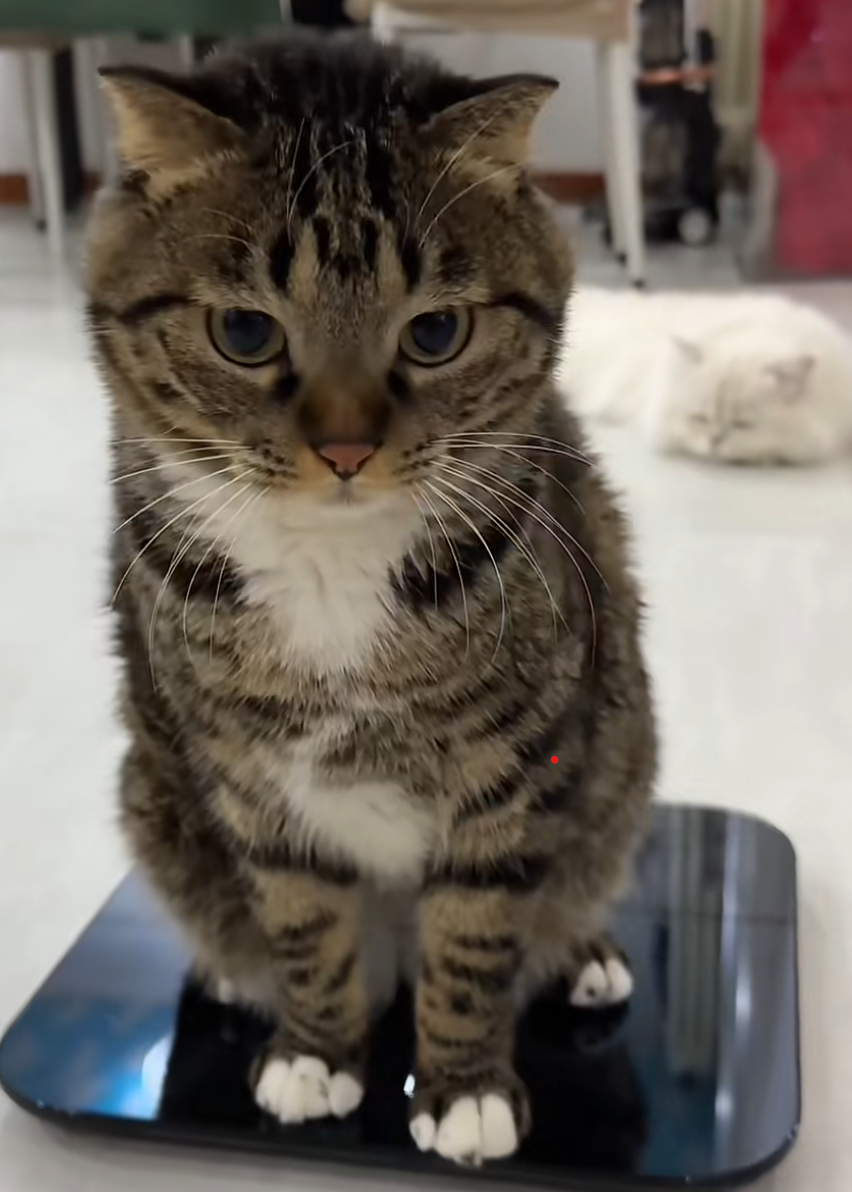

In [ ]:
image_cat = Image.open("/content/cat.png")
image_cat.show()

In [ ]:
#classes = ('plane', 'car', 'bird', 'cat', 'deer',
#           'dog', 'frog', 'horse', 'ship', 'truck')

prediction1 = np.argmax(net(cat).cpu().detach().numpy()) 
print('Predict a cat image as: ', classes[prediction1])

Predict a cat image as:  cat
